# Data Assessment & Analytics
- Analyze and view the processed WaDE data.

Goals
- Need to back proprigate from allocatoinamounts to sites and watersourrces, and remove the unused sites not tied to allocatoinamounts record, and the unused watersources not tied to a site.
- Want to use this to also automate which records could be used due to missing key WaDE info.
- Maybe remove the WaDEUUID value here after you have inspected those records.

In [1]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps

# visulizaiton
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # creates a matrix chart to show missing values
import plotly.express as px

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Set Working Directory
workingDir = "G:/Shared drives/WaDE Data/California/WaterAllocation" # change here
os.chdir(workingDir)

In [3]:
# Input Data
fileInput = "ProcessedInputData/watersources.csv"
dfws = pd.read_csv(fileInput).replace(np.nan, "")

fileInput = "ProcessedInputData/sites.csv" 
dfs = pd.read_csv(fileInput).replace(np.nan, "")

fileInput = "ProcessedInputData/waterallocations.csv"
dfaa = pd.read_csv(fileInput).replace(np.nan, "")

In [4]:
# Plotting function that we can re-use
def show_distribution(var_data):
    '''
    This function will make a distribution (graph) and display it
    '''
    
    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]
    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val, mean_val, med_val, mod_val, max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,6))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle('Data Distribution')

    # Show the figure
    fig.show()

# Remove unsed Site and Water Source Information
- I need to add the removed records to the purge files still...


In [5]:
# Remove unused sites from sites.csv not in waterallocations.csv
print(f'Length of dfs before removing sites: ', len(dfs))

############################################################################
# explode copy of waterallocations.csv on SiteUUID
dfaaTemp = dfaa.copy()
dfaaTemp = dfaaTemp.assign(SiteUUID=dfaaTemp['SiteUUID'].str.split(',')).explode('SiteUUID').reset_index(drop=True)

# create list of & SiteUUIDs from copy of waterallocations.csv
dfaaSiteUUID_List = dfaaTemp['SiteUUID'].drop_duplicates().to_list()
dfaaSiteUUID_List.sort()

# use list to only save used SiteUUID records in site.csv
dfs = dfs[dfs['SiteUUID'].isin(dfaaSiteUUID_List)].reset_index(drop=True)

# Export to new csv
############################################################################
dfs.to_csv('ProcessedInputData/sites.csv', index=False)

print(f'Length of dfs after removing sites: ', len(dfs))

Length of dfs before removing sites:  52055
Length of dfs after removing sites:  25636


In [6]:
# Remove unused water source records from sites.csv
# 'WaterSourceUUIDs' in sites.csv & 'WaterSourceUUID' in watersource.csv
print(f'Length of dfws before removing water sources: ', len(dfws))

############################################################################
# explode copy of sites.csv on WaterSourceUUID
dfsTemp = dfs.copy()
dfsTemp = dfsTemp.assign(WaterSourceUUIDs=dfsTemp['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# create list of & WaterSourceUUID from copy of sites.csv
dfsWaterSourceUUID_List = dfsTemp['WaterSourceUUIDs'].drop_duplicates().to_list()
dfsWaterSourceUUID_List.sort()

# use list to only save used SiteUUID records in site.csv
dfws = dfws[dfws['WaterSourceUUID'].isin(dfsWaterSourceUUID_List)].reset_index(drop=True)

# Export to new csv
############################################################################
dfws.to_csv('ProcessedInputData/watersources.csv', index=False)

print(f'Length of dfws after removing water sources: ', len(dfws))

Length of dfws before removing water sources:  9656
Length of dfws after removing water sources:  6695


# Water Source Info
- check for unique CV terminology

In [7]:
print(len(dfws))
dfws.head(1)

6695


WaterSourceUUID Geometry GNISFeatureNameCV WaterQualityIndicatorCV  \
0        CAwr_WS1                                              Fresh   

  WaterSourceName WaterSourceNativeID WaterSourceTypeCV  
0     Unspecified          WaDECA_WS1       Unspecified

In [8]:
msno.matrix(dfws, figsize=(10,5), fontsize=10)

<AxesSubplot: >

In [9]:
for x in dfws['WaterSourceTypeCV'].sort_values().unique():
    print(f'"' + x + '",')

"Subsurface",
"Surface",
"Unspecified",


# Site Info
- check for unique CV terminology.
- check for missing info.
- check distribution of some key values.

In [10]:
print(len(dfs))
dfs.head(1)

25636


SiteUUID RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  CAwr_S94                              CAwr_WS462        Unspecified   

  CoordinateMethodCV     County  EPSGCodeCV Geometry GNISCodeCV         HUC12  \
0              DD_NE  El Dorado        4326                      1.804000e+11   

         HUC8   Latitude  Longitude NHDNetworkStatusCV NHDProductCV  \
0  18040013.0  38.675975 -120.67975                                   

  PODorPOUSite     SiteName SiteNativeID SitePoint   SiteTypeCV StateCV  \
0          POD  Unspecified    CA10096.0            Unspecified      CA   

  USGSSiteID  
0

<AxesSubplot: >

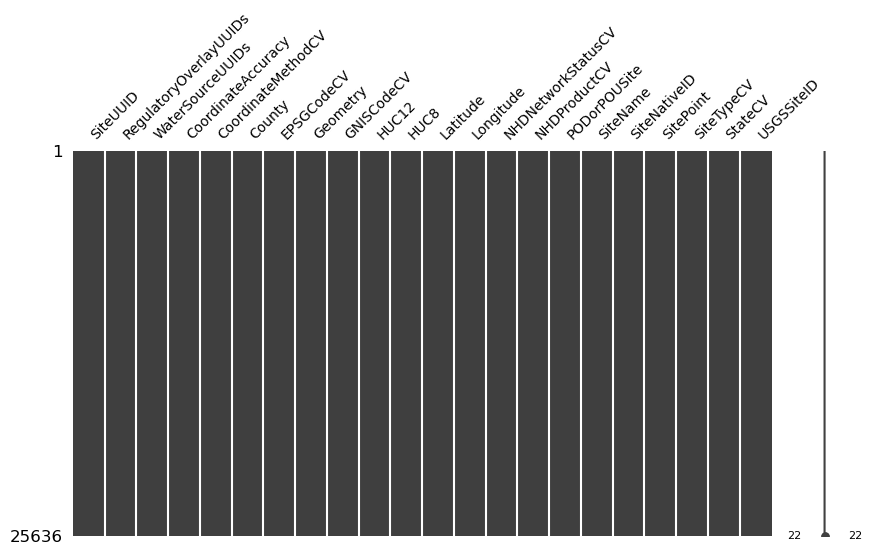

In [11]:
msno.matrix(dfs, figsize=(10,5), fontsize=10)

In [12]:
for x in dfs['CoordinateMethodCV'].sort_values().unique():
    print(f'"' + x + '",')

"DD_NE",
"DD_QQS",
"DD_QS",
"DD_S",
"GIS_CLICK",
"GIS_DDO",
"GIS_LL",
"GIS_NE",
"GIS_UTM",


In [13]:
for x in dfs['SiteTypeCV'].sort_values().unique():
    print(f'"' + x + '",')

"Unspecified",


# Allocation Amount Info
- check for unique CV terminology

In [14]:
print(len(dfaa))
dfaa.head(3)

25636


AllocationUUID MethodUUID OrganizationUUID     SiteUUID  \
0       CAwr_WR1    CAwr_M1          CAwr_O1  CAwr_S17128   
1       CAwr_WR2    CAwr_M1          CAwr_O1  CAwr_S29816   
2       CAwr_WR3    CAwr_M1          CAwr_O1  CAwr_S29817   

  VariableSpecificUUID AllocationApplicationDate  \
0              CAwr_V1                 7/22/1915   
1              CAwr_V1                 4/17/1916   
2              CAwr_V1                 4/28/1916   

  AllocationAssociatedConsumptiveUseSiteIDs  \
0                                             
1                                             
2                                             

  AllocationAssociatedWithdrawalSiteIDs AllocationBasisCV  \
0                                                           
1                                                           
2                                                           

  AllocationChangeApplicationIndicator AllocationCommunityWaterSupplySystem  \
0                                                                             
1                                                                             
2                                                                             

  AllocationCropDutyAmount AllocationExpirationDate  AllocationFlow_CFS  \
0                                                                   2.5   
1                                                                   0.0   
2                                                                   0.0   

  AllocationLegalStatusCV AllocationNativeID                  AllocationOwner  \
0                Licensed            A000084  MORONGO BAND OF MISSION INDIANS   
1                Licensed            A000301    WEST SIDE IRRIGATION DISTRICT   
2                 Revoked            A000321                    HELEN COOKSEY   

  AllocationPriorityDate AllocationSDWISIdentifierCV AllocationTimeframeEnd  \
0             07/22/1915                                             30-Nov   
1             04/17/1916                                             31-Oct   
2             04/28/1916                                              1-Oct   

  AllocationTimeframeStart AllocationTypeCV  AllocationVolume_AF  \
0                    1-Apr    Appropriative                  0.0   
1                    1-Apr    Appropriative                  0.0   
2                    1-May    Appropriative                  0.0   

  BeneficialUseCategory CommunityWaterSupplySystem CropTypeCV CustomerTypeCV  \
0            Irrigation                                                        
1            Irrigation                                                        
2              Domestic                                                        

  DataPublicationDate DataPublicationDOI  ExemptOfVolumeFlowPriority  \
0          02/23/2023                                              0   
1          02/23/2023                                              0   
2          02/23/2023                                              0   

  GeneratedPowerCapacityMW IrrigatedAcreage IrrigationMethodCV  \
0                                                                
1                                                                
2                                                                

  LegacyAllocationIDs OwnerClassificationCV PopulationServed PowerType  \
0                           Native American                              
1                                 In Review                              
2                                 In Review                              

  PrimaryBeneficialUseCategory WaterAllocationNativeURL  
0       Agriculture Irrigation                           
1       Agriculture Irrigation                           
2                     Domestic

In [15]:
for x in dfaa['AllocationBasisCV'].sort_values().unique():
    print(f'"' + str(x) + '",')

"",


In [16]:
for x in dfaa['AllocationTypeCV'].sort_values().unique():
    print(f'"' + x + '",')

"Adjudicated",
"Appropriative",
"Groundwater Recordation",
"Not Determined_RIPERIAN",
"Registration Cannabis",
"Registration Domestic",
"Registration Irrigation",
"Registration Livestock",
"Section 12 File",
"Statement of Div and Use",
"Statement of Div and Use_COURTADJ",
"Statement of Div and Use_COURTADJ,OTHER",
"Statement of Div and Use_OTHER",
"Statement of Div and Use_PENDING",
"Statement of Div and Use_PENDING,OTHER",
"Statement of Div and Use_PRE1914",
"Statement of Div and Use_PRE1914,COURTADJ",
"Statement of Div and Use_PRE1914,COURTADJ,OTHER",
"Statement of Div and Use_PRE1914,OTHER",
"Statement of Div and Use_PRE1914,PENDING",
"Statement of Div and Use_RIPERIAN",
"Statement of Div and Use_RIPERIAN,COURTADJ",
"Statement of Div and Use_RIPERIAN,COURTADJ,OTHER",
"Statement of Div and Use_RIPERIAN,OTHER",
"Statement of Div and Use_RIPERIAN,PENDING",
"Statement of Div and Use_RIPERIAN,PENDING,OTHER",
"Statement of Div and Use_RIPERIAN,PRE1914",
"Statement of Div and Use_RIPERIAN,

In [17]:
for x in dfaa['BeneficialUseCategory'].sort_values().unique():
    print(f'"' + x + '",')

"Aesthetic",
"Aquaculture",
"Domestic",
"Dust Control",
"Fire Protection",
"Fish and Wildlife Preservation and Enhancement",
"Frost Protection",
"Heat Control",
"Incidental Power",
"Industrial",
"Irrigation",
"Milling",
"Mining",
"Municipal",
"Other",
"Power",
"Recreational",
"Snow Making",
"Stockwatering",
"Unspecified",


In [18]:
for x in dfaa['OwnerClassificationCV'].sort_values().unique():
    print(f'"' + x + '",')

"Bureau Reclamation (USBR)",
"Bureau of Land Management (USBLM)",
"Department of Agriculture (USDA)",
"Fish and Wildlife Service (USFWS)",
"Forest Service (USFS)",
"In Review",
"Military",
"National Park Service (USNPS)",
"Native American",
"United States of America",
"Unspecified",


<AxesSubplot: >

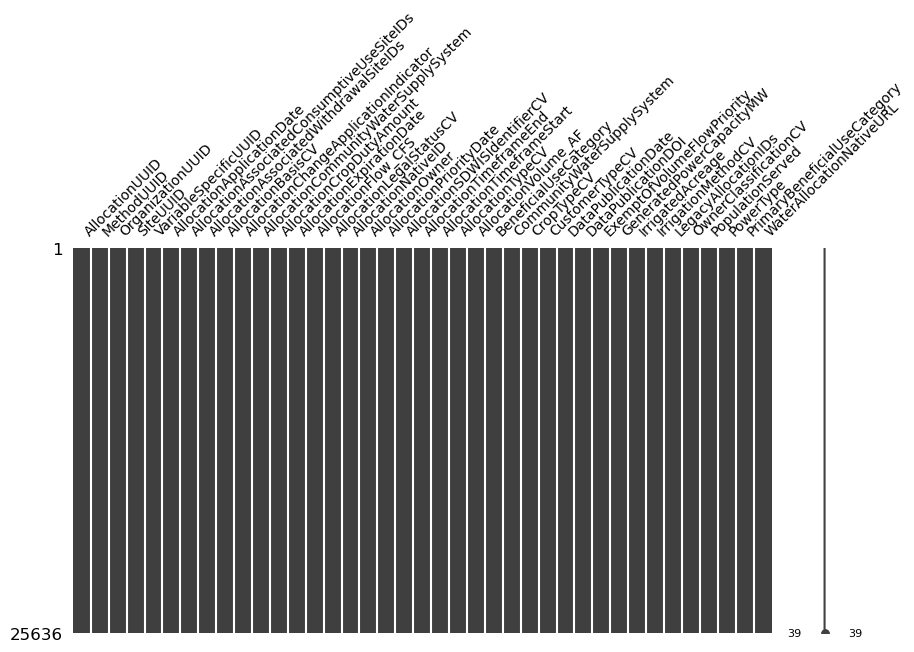

In [19]:
msno.matrix(dfaa, figsize=(10,5), fontsize=10)

Minimum:0.00
Mean:6.47
Median:0.00
Mode:0.00
Maximum:31104.00



C:\Users\rjame\AppData\Local\Temp\ipykernel_13816\1120514692.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


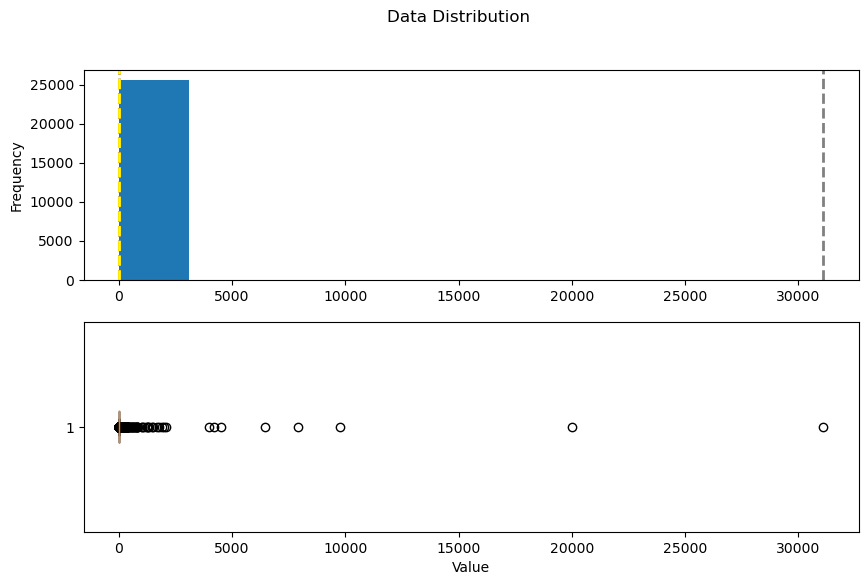

In [20]:
# AllocationFlow_CFS
try: show_distribution(dfaa['AllocationFlow_CFS'])
except: print('could not plot AllocationFlow_CFS value')

Minimum:0.00
Mean:0.01
Median:0.00
Mode:0.00
Maximum:365.00



C:\Users\rjame\AppData\Local\Temp\ipykernel_13816\1120514692.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


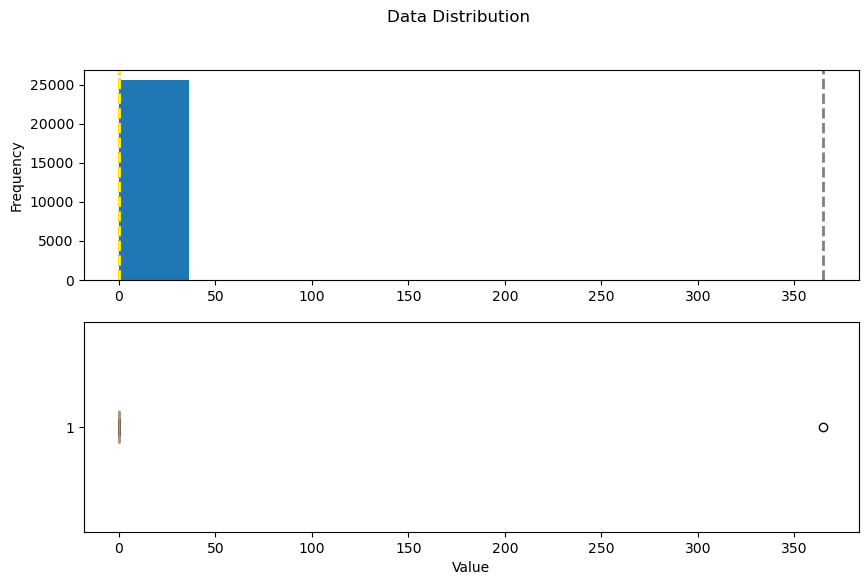

In [21]:
# AllocationVolume_AF
try: show_distribution(dfaa['AllocationVolume_AF'])
except: print('could not plot AllocationVolume_AF value')

In Review                            22636
Bureau of Land Management (USBLM)     1542
National Park Service (USNPS)         1009
Unspecified                            258
Forest Service (USFS)                   79
Department of Agriculture (USDA)        47
United States of America                32
Native American                         19
Bureau Reclamation (USBR)                9
Military                                 4
Fish and Wildlife Service (USFWS)        1
Name: OwnerClassificationCV, dtype: int64


<AxesSubplot: >

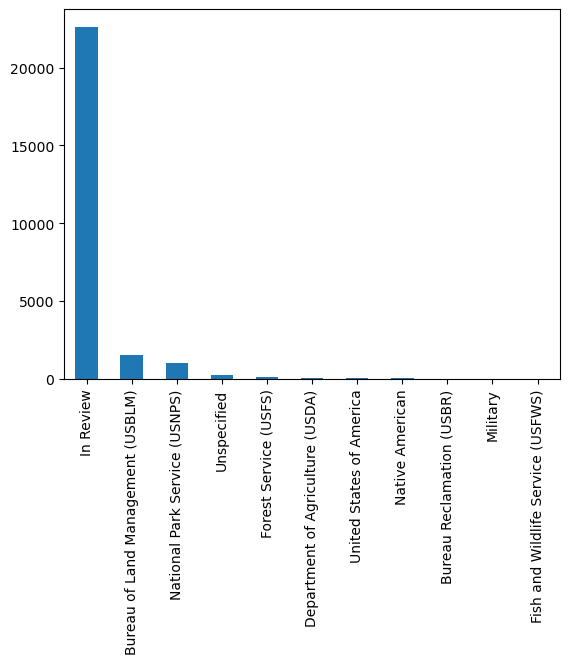

In [22]:
print(dfaa['OwnerClassificationCV'].value_counts())
dfaa['OwnerClassificationCV'].value_counts().plot(kind='bar')

Agriculture Irrigation    9192
Domestic                  7226
Other                     2815
In-stream Flow            2701
Livestock                 1771
Fire                       805
Hydroelectric              199
Recreation                 178
Public Supply              152
Unspecified                149
Commercial/Industrial      146
Aquaculture                130
Municipal Irrigation       111
Mining                      47
Thermoelectric Cooling      10
Snow                         4
Name: PrimaryBeneficialUseCategory, dtype: int64


<AxesSubplot: >

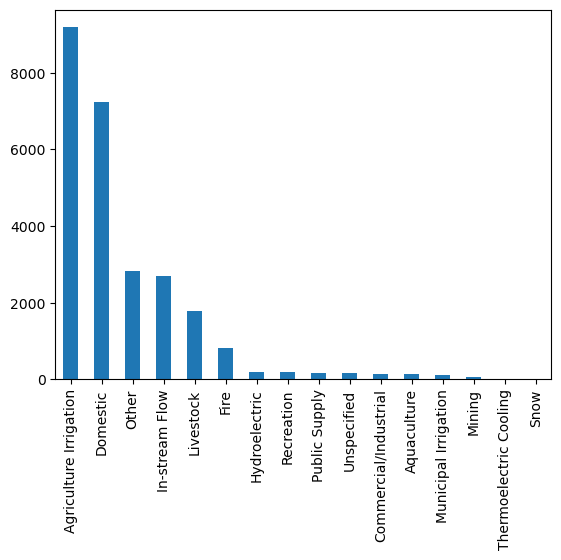

In [23]:
print(dfaa['PrimaryBeneficialUseCategory'].value_counts())
dfaa['PrimaryBeneficialUseCategory'].value_counts().plot(kind='bar')

In [24]:
# anlytic for priroity date
# maybe a bar chart?

In [25]:
# shoudl incdlue some pie chart stuff too